# PART 1 : DATASET EXPLORATION

STEP 1 : GETTING INFORMATIONS ABOUT THE DATASET TRAIN

In [1]:
# Loading librairies needeed
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import en_core_web_lg
from spacy.lang.en import STOP_WORDS

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
import keras.backend as K
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

2022-11-26 08:14:44.086477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Downloading the large english dictionary
!python -m spacy download en_core_web_lg -q

2022-11-26 08:14:51.803432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
# Loading the dataset train
dataset = pd.read_csv("src/train.csv")

In [4]:
# Visualize the first 5 rows of the dataset
dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Checking the shape of the dataset
dataset.shape

(7613, 5)

STEP 2 : MISSING VALUES MANAGEMENT

In [6]:
# Checking missing value
dataset.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
# Visualize some analytic figure of the dataset
dataset.describe(include="all")

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [8]:
# Deleting useless columns
columns_to_drop = ['id', 'keyword','location']
dataset = dataset.drop(columns=columns_to_drop, axis=1)

STEP 3 : PREPROCESSING TEXT

In [9]:
# Importing the dictionary and intanciating english language into the variable 'nlp'
import en_core_web_lg
nlp = en_core_web_lg.load()

In [10]:
# Importing string punctuation to get rid of it on text
import string 
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
# Removing punctuation, lower case, space, lemmatized word on all documents
dataset['clean_text'] = dataset['text'].str.replace(r"[!\"#$%&()*+,-./:;<=>?@[\\\]^_`'{|}~]+", " ") 
dataset["clean_text"] = dataset["clean_text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
dataset["clean_text"] = dataset["clean_text"].apply(lambda x: x.lower().strip())
dataset["clean_text"] = dataset["clean_text"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) 
                                                                                if (token.lemma_ not in STOP_WORDS) 
                                                                                and (token.text not in STOP_WORDS)]))

In [12]:
# Checking transformations
dataset.head()

,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer ...
3,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfire evacuation or...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire ...


In [13]:
## Tokenize the cleaned document
dataset['tokenized_text'] = (dataset['clean_text'].apply(lambda x: nlp(x)))

In [14]:
# Checking the 'tokenize_text'
dataset.head()

,text,target,clean_text,tokenized_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"(deed, reason, , earthquake, allah, forgive)"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"(forest, fire, near, la, ronge, sask, , canada)"
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer ...,"(resident, ask, , shelter, place, , notify..."
3,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfire evacuation or...,"(13, 000, people, receive, , wildfire, evacu..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire ...,"(got, send, photo, ruby, , alaska, smoke, ..."


In [15]:
# Encoding the text
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(dataset.clean_text)
dataset["encoded_text"] = tokenizer.texts_to_sequences(dataset.clean_text)

In [16]:
# Checking the encoded transformation
dataset.head()

,text,target,clean_text,tokenized_text,encoded_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"(deed, reason, , earthquake, allah, forgive)","[1, 454, 197, 1, 1]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"(forest, fire, near, la, ronge, sask, , canada)","[135, 9, 176, 623, 1, 1, 1]"
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer ...,"(resident, ask, , shelter, place, , notify...","[1, 492, 1, 366, 1, 317, 198, 1, 366, 349, 423]"
3,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfire evacuation or...,"(13, 000, people, receive, , wildfire, evacu...","[624, 1, 13, 1, 92, 198, 349, 43]"
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire ...,"(got, send, photo, ruby, , alaska, smoke, ...","[283, 202, 130, 1, 1, 199, 92, 1, 124]"


In [17]:
# Padding the 'encoded_text'
tweets_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset.encoded_text, padding="post")
# keep the length to predictions
maxlen = tweets_pad.shape[1]

In [18]:
# Checking the padding
dataset.head()

,text,target,clean_text,tokenized_text,encoded_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"(deed, reason, , earthquake, allah, forgive)","[1, 454, 197, 1, 1]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"(forest, fire, near, la, ronge, sask, , canada)","[135, 9, 176, 623, 1, 1, 1]"
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer ...,"(resident, ask, , shelter, place, , notify...","[1, 492, 1, 366, 1, 317, 198, 1, 366, 349, 423]"
3,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfire evacuation or...,"(13, 000, people, receive, , wildfire, evacu...","[624, 1, 13, 1, 92, 198, 349, 43]"
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire ...,"(got, send, photo, ruby, , alaska, smoke, ...","[283, 202, 130, 1, 1, 199, 92, 1, 124]"


In [19]:
tokenizer.index_word

{1: 'out_of_vocab',
 2: 't',
 3: 'co',
 4: 'http',
 5: 's',
 6: 'https',
 7: 'like',
 8: 'm',
 9: 'fire',
 10: 'amp',
 11: 'new',
 12: '2',
 13: 'people',
 14: 'news',
 15: 'year',
 16: 'burn',
 17: 'video',
 18: 'kill',
 19: 'don',
 20: 'crash',
 21: 'bomb',
 22: 'disaster',
 23: 'come',
 24: 'emergency',
 25: 'good',
 26: 'body',
 27: 'attack',
 28: 'time',
 29: '3',
 30: 'day',
 31: 'man',
 32: 'look',
 33: 'home',
 34: 'police',
 35: 'know',
 36: 'flood',
 37: 'u',
 38: 'love',
 39: 'family',
 40: 'building',
 41: 'think',
 42: 'storm',
 43: 'california',
 44: '1',
 45: 'suicide',
 46: 'want',
 47: 'train',
 48: 'watch',
 49: 'collapse',
 50: 'bag',
 51: 'life',
 52: 'world',
 53: 'car',
 54: 'death',
 55: 'work',
 56: 'scream',
 57: 'rt',
 58: '5',
 59: 'cause',
 60: 'nuclear',
 61: 'today',
 62: 'need',
 63: 'war',
 64: 'drown',
 65: 'd',
 66: '4',
 67: 'wreck',
 68: 'youtube',
 69: 'dead',
 70: 'accident',
 71: 'old',
 72: 'destroy',
 73: 'gt',
 74: 'let',
 75: 'hiroshima',
 76:

In [20]:
len(tokenizer.index_word)

19667

STEP 4 : APPLICATION OF THE MODEL OF DEEP LEARNING WITH NEURAL NETWORK

In [21]:
# Defintion to get the F1 SCORE
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [22]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(tweets_pad,dataset.target, test_size=0.3)

In [23]:
# Slicing the data
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

2022-11-26 08:21:47.943488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
# Shuffling then Batching
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [25]:
 #Let"s view a batch
for text, real in train_batch.take(1):
  print(text, real)

tf.Tensor(
[[  1   1 554 ...   0   0   0]
 [ 32 204 496 ...   0   0   0]
 [180   1   1 ...   0   0   0]
 ...
 [ 57   1 885 ...   0   0   0]
 [  1   1   1 ...   0   0   0]
 [147 453  22 ...   0   0   0]], shape=(64, 30), dtype=int32) tf.Tensor(
[1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 1 0 0 0
 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1], shape=(64,), dtype=int64)


STEP 5 : MODELING

In [26]:
vocab_size = len(tokenizer.index_word)

model = tf.keras.Sequential([
                   # Word Embedding layer       
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[text.shape[1]],name="embedding"),
                  
                  # Global average pooling
                  tf.keras.layers.GlobalAveragePooling1D (), 
                  
                  # Dense layers once the data is flat
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),
                  
                  # output layer for the target and sigmoid activation
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 128)           2517504   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                        

In [28]:
# Compiling the model with the correst loss function and the Adam optimizer, metrics = F1-score as request
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[get_f1])


In [29]:
# Fitting the model on 20 epochs with weights to penalize too frequent notes
history = model.fit(train_batch,
                epochs=10,
                validation_data=val_batch
                )

Epoch 1/10
84/84 [==============================] - 3s 18ms/step - loss: 0.6697 - get_f1: 0.1253 - val_loss: 0.6134 - val_get_f1: 0.5632
Epoch 2/10
84/84 [==============================] - 1s 16ms/step - loss: 0.5315 - get_f1: 0.6798 - val_loss: 0.4629 - val_get_f1: 0.7205
Epoch 3/10
84/84 [==============================] - 1s 16ms/step - loss: 0.4151 - get_f1: 0.7738 - val_loss: 0.4579 - val_get_f1: 0.7319
Epoch 4/10
84/84 [==============================] - 1s 18ms/step - loss: 0.3804 - get_f1: 0.7924 - val_loss: 0.4833 - val_get_f1: 0.7244
Epoch 5/10
84/84 [==============================] - 1s 18ms/step - loss: 0.3645 - get_f1: 0.8024 - val_loss: 0.4614 - val_get_f1: 0.7335
Epoch 6/10
84/84 [==============================] - 1s 17ms/step - loss: 0.3528 - get_f1: 0.8085 - val_loss: 0.4820 - val_get_f1: 0.7197
Epoch 7/10
84/84 [==============================] - 1s 17ms/step - loss: 0.3489 - get_f1: 0.8124 - val_loss: 0.4801 - val_get_f1: 0.7248
Epoch 8/10
84/84 [=======================

STEP 6 : VISUALIZE MODEL PERFORMANCE

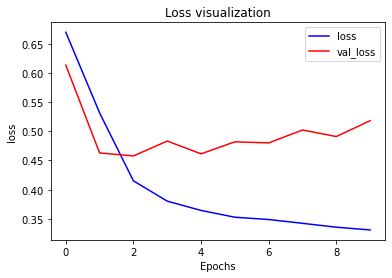

In [30]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.title("Loss visualization")
plt.legend(['loss','val_loss'], loc ="upper right")
plt.show()

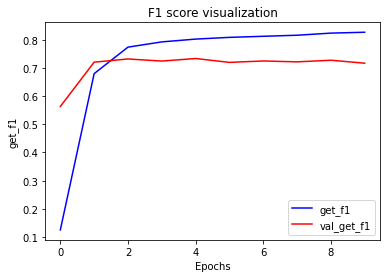

In [31]:
# Visualization of the training process on the loss function 
plt.plot(history.history["get_f1"], color="b")
plt.plot(history.history["val_get_f1"], color="r")
plt.ylabel("get_f1")
plt.xlabel("Epochs")
plt.legend(['get_f1','val_get_f1'], loc ="lower right")
plt.title("F1 score visualization")
plt.show()

## PREDICTION FOR SUBMISSION WITH TEST.CSV

STEP 1 : GETTING INFORMATIONS ABOUT THE DATASET - TEST

In [32]:
# Loading the dataset
data_test = pd.read_csv('src/test.csv')

In [33]:
# Visualize the first 5 rows of the dataset
data_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [34]:
# Checking the shape
data_test.shape

(3263, 4)

In [35]:
# Deleting the useless column
data_test = data_test.drop(columns= ['keyword', 'location'])

In [36]:
data_test.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [37]:
# Checking the shape
data_test.shape

(3263, 2)

STEP 2 : DATA CLEANING/PREPROCESSING

In [38]:
# Remove punctuation and lower case all doc 
data_test['clean_text'] = data_test['text'].str.replace(r"[!\"#$%&()*+,-./:;<=>?@[\\\]^_`'{|}~]+", " ") 
data_test["clean_text"] = data_test["clean_text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
data_test["clean_text"] = data_test["clean_text"].apply(lambda x: x.replace(" +"," ").lower().strip())
data_test["clean_text"] = data_test["clean_text"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

In [39]:
data_test.head()

,id,text,clean_text
0,0,Just happened a terrible car crash,happen terrible car crash
1,2,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose flee street save
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan


In [40]:
# Encoding the text
data_test["encoded_text"] = tokenizer.texts_to_sequences(data_test.clean_text)

In [41]:
# Checking transformation
data_test.head()

,id,text,clean_text,encoded_text
0,0,Just happened a terrible car crash,happen terrible car crash,"[211, 1, 53, 20]"
1,2,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[150, 197, 985, 132, 392, 1]"
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose flee street save,"[135, 9, 572, 1, 1, 1, 424, 116]"
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[409, 1, 1, 92]"
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,"[175, 552, 18, 1, 380, 989]"


In [42]:
data_test["len_text"] = data_test['encoded_text'].apply(lambda x: len(x))

In [43]:
test = data_test[data_test["clean_text"]!=0]
test_pad = tf.keras.preprocessing.sequence.pad_sequences(data_test.encoded_text, padding="post",maxlen=maxlen)

In [44]:
max_len = max(data_test['encoded_text'].apply(lambda x : len(x)))
if  max_len < 25:
    test_pad = tf.keras.preprocessing.sequence.pad_sequences(data_test.encoded_text, padding = 'post', maxlen=maxlen)

In [45]:
test_pad

array([[211,   1,  53, ...,   0,   0,   0],
       [150, 197, 985, ...,   0,   0,   0],
       [135,   9, 572, ...,   0,   0,   0],
       ...,
       [735, 487, 304, ...,   0,   0,   0],
       [  1, 179, 338, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0]], dtype=int32)

STEP 4 : INPUT THE MODEL TO PREDICT

In [46]:
data_test['model_preds'] = model.predict(test_pad)
data_test['target'] = data_test['model_preds'].apply(lambda x: 1 if x >= 0.5 else 0)
data_test.head()

102/102 [==============================] - 0s 1ms/step


,id,text,clean_text,encoded_text,len_text,model_preds,target
0,0,Just happened a terrible car crash,happen terrible car crash,"[211, 1, 53, 20]",4,0.895897,1
1,2,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[150, 197, 985, 132, 392, 1]",6,0.986200,1
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose flee street save,"[135, 9, 572, 1, 1, 1, 424, 116]",8,0.679623,1
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[409, 1, 1, 92]",4,0.977263,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,"[175, 552, 18, 1, 380, 989]",6,0.994624,1


In [47]:
# Shaping prediction for submission
predictions = data_test[['id', 'target']]
predictions.head(20)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [48]:
# Save the predictions into a csv file for submission as request
predictions.to_csv('submission.csv', header = True, index = False)

# To go further check the tweet

In [49]:
data_test.head()


,id,text,clean_text,encoded_text,len_text,model_preds,target
0,0,Just happened a terrible car crash,happen terrible car crash,"[211, 1, 53, 20]",4,0.895897,1
1,2,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[150, 197, 985, 132, 392, 1]",6,0.986200,1
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose flee street save,"[135, 9, 572, 1, 1, 1, 424, 116]",8,0.679623,1
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[409, 1, 1, 92]",4,0.977263,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,"[175, 552, 18, 1, 380, 989]",6,0.994624,1


In [55]:
mask1 = data_test['target'] == 1
data_view1 = data_test.loc[mask1, 'text']

In [56]:
data_view1

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3257    The death toll in a #IS-suicide car bombing on...
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
Name: text, Length: 1476, dtype: object

In [58]:
mask2 = data_test['target'] == 0
data_view0 = data_test.loc[mask2, 'text']
data_view0

6       They'd probably still show more life than Arse...
7                                       Hey! How are you?
8                                        What a nice hat?
9                                               Fuck off!
10                                  No I don't like cold!
                              ...                        
3248    Smackdown tyme this should put me in a good mo...
3249    @thrillhho jsyk I haven't stopped thinking abt...
3250    @stighefootball Begovic has been garbage. He g...
3251                   Wrecked today got my hattrick ????
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 1787, dtype: object